In [1]:
%matplotlib inline

import sys
sys.path.insert(0, "ladybug")
sys.path.insert(0, "honeybee")

import ladybug
import honeybee

import json
import itertools
import re
import os

from scipy.spatial import Delaunay

import eppy
from eppy import modeleditor
from eppy.modeleditor import IDF
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def loadJSON(path):
    """
    Description:
        Load a JSON file into a dictionary object
    Arguments:
        path [string]: The location of the JSON file being loaded
    Returns:
        dictionary [dict]: Dictionary containing contents of loaded JSON file 
    """
    import json
    with open(path) as data_file:
        return json.load(data_file)

# Load IDF ready for pre-processing and modification
idf_file = "test_basic.idf"
idd_file = "/Applications/EnergyPlus-8-8-0/Energy+.idd" if os.name == "posix" else "C:/EnergyPlusV8-8-0/Energy+.idd"
epw_file = "GBR_Cardiff_CIBSE_TRY.epw" 

IDF.setiddname(idd_file)
idf = IDF(idf_file)

# Load the JSON file containing internal gains, schedules and setpoints
internal_gains_library = loadJSON("internal_gains_library.json")

# Specify the zone template to use
zone_template = "Computer Labs"

# Give surface reflectivity and u-values
wall_reflectivity = 0.5
ceiling_reflectivity = 0.7
floor_reflectivity = 0.2

exterior_wall_u_value = 0.3
exterior_roof_u_value = 0.18

Solar_Heat_Gain_Coefficient = 0.3 
Visible_Transmittance = 0.65
Glazing_U_Value = 1.6

#Load the EPW file to get the location variables and store in the IDF object
with open(epw_file, "r") as f:
    a, b, c, d, e, f, g, h, i, j = f.readlines()[0].replace("\n", "").split(",")
idf.idfobjects["SITE:LOCATION"] = []
idf.newidfobject('SITE:LOCATION',  Name=b, Latitude=float(g), Longitude=float(h), Time_Zone=float(i), Elevation=float(j),)

# Set version number
idf.idfobjects["VERSION"] = []
idf.newidfobject('VERSION', Version_Identifier="8.8.0")

# Remove Design Day sizing periods
idf.idfobjects["SIZINGPERIOD:DESIGNDAY"] = []

# Remove surface output (to save on simulation time and results size)
idf.idfobjects['OUTPUT:SURFACES:LIST'] = []

# Remove table style output to save on results file size
idf.idfobjects["OUTPUTCONTROL:TABLE:STYLE"] = []

# Set/remove sizing parameters
idf.idfobjects["SIZING:PARAMETERS"] = []
#idf.newidfobject("SIZING:PARAMETERS", Heating_Sizing_Factor=1.25, Cooling_Sizing_Factor=1.15)

# Remove the HVAC objects provifing fresh air from outside
idf.idfobjects["DESIGNSPECIFICATION:OUTDOORAIR"] = []

# Set simulation to run only for annual period corresponding with weatherfile
idf.idfobjects["SIMULATIONCONTROL"] = []
idf.newidfobject("SIMULATIONCONTROL", Do_Zone_Sizing_Calculation="No", Do_System_Sizing_Calculation="No", Do_Plant_Sizing_Calculation="No", Run_Simulation_for_Sizing_Periods="No", Run_Simulation_for_Weather_File_Run_Periods="Yes")

# Set simulation run period (including start day of year)
idf.idfobjects["RUNPERIOD"] = []
idf.newidfobject("RUNPERIOD", Name="Custom Run", Begin_Month=1, Begin_Day_of_Month=1, End_Month=12, End_Day_of_Month=31, Day_of_Week_for_Start_Day="Monday", Use_Weather_File_Holidays_and_Special_Days="Yes", Use_Weather_File_Daylight_Saving_Period="Yes", Apply_Weekend_Holiday_Rule="No", Use_Weather_File_Rain_Indicators="Yes", Use_Weather_File_Snow_Indicators="Yes")

# Remove output variable dictionary
idf.idfobjects["OUTPUT:VARIABLEDICTIONARY"] = []

# Set general building parameters (including North angle)
idf.idfobjects["BUILDING"] = []
idf.newidfobject("BUILDING", Name="IDF Name", North_Axis=0, Terrain="City", Solar_Distribution="FullExteriorWithReflections", Maximum_Number_of_Warmup_Days=25, Minimum_Number_of_Warmup_Days=6)

# Set number of timesteps per hour in simulation
idf.idfobjects["TIMESTEP"] = []
idf.newidfobject("TIMESTEP", Number_of_Timesteps_per_Hour=6)

# Set shadow calculation method
idf.idfobjects["SHADOWCALCULATION"] = []
idf.newidfobject("SHADOWCALCULATION", Calculation_Method="AverageOverDaysInFrequency", Calculation_Frequency=20, Maximum_Figures_in_Shadow_Overlap_Calculations=1000)

# Set schedule type limits
idf.idfobjects["SCHEDULETYPELIMITS"] = []
idf.newidfobject("SCHEDULETYPELIMITS", Name="FractionLimits", Lower_Limit_Value=0, Upper_Limit_Value=1, Numeric_Type="Continuous", Unit_Type="Dimensionless")
idf.newidfobject("SCHEDULETYPELIMITS", Name="OnOffLimits", Lower_Limit_Value=0, Upper_Limit_Value=1, Numeric_Type="Discrete", Unit_Type="Dimensionless")
idf.newidfobject("SCHEDULETYPELIMITS", Name="TemperatureSetpointLimits", Lower_Limit_Value=0, Upper_Limit_Value=100, Numeric_Type="Continuous", Unit_Type="Dimensionless")
idf.newidfobject("SCHEDULETYPELIMITS", Name="ActivityLevelLimits", Lower_Limit_Value=0, Upper_Limit_Value=1000, Numeric_Type="Continuous", Unit_Type="Dimensionless")

# Set daily profiles from the internal gains templates
idf.idfobjects["SCHEDULE:DAY:INTERVAL"] = []
idf.idfobjects["SCHEDULE:DAY:HOURLY"] = []

# Set a daily Always On profile
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="AlwaysOnDay", Schedule_Type_Limits_Name="OnOffLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = 1

# Set a daily Always Off profile
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="AlwaysOffDay", Schedule_Type_Limits_Name="OnOffLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = 0

# Set daily cooling profile from JSON
setpoint = internal_gains_library[zone_template]["cooling_setpoint"]
setback = internal_gains_library[zone_template]["cooling_setback"]
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="CoolingSetpointDayWeekday", Schedule_Type_Limits_Name="TemperatureSetpointLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = setpoint if internal_gains_library[zone_template]["cooling_setpoint_weekday"]["Hour_{0:}".format(i+1)] == 0 else setback
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="CoolingSetpointDayWeekend", Schedule_Type_Limits_Name="TemperatureSetpointLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = setpoint if internal_gains_library[zone_template]["cooling_setpoint_weekend"]["Hour_{0:}".format(i+1)] == 0 else setback

# Set daily heating profile from JSON
setpoint = internal_gains_library[zone_template]["heating_setpoint"]
setback = internal_gains_library[zone_template]["heating_setback"]
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="HeatingSetpointDayWeekday", Schedule_Type_Limits_Name="TemperatureSetpointLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = setpoint if internal_gains_library[zone_template]["heating_setpoint_weekday"]["Hour_{0:}".format(i+1)] == 0 else setback
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="HeatingSetpointDayWeekend", Schedule_Type_Limits_Name="TemperatureSetpointLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = setpoint if internal_gains_library[zone_template]["heating_setpoint_weekend"]["Hour_{0:}".format(i+1)] == 0 else setback

# Set a daily Occupant profile
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="OccupantGainDayWeekday", Schedule_Type_Limits_Name="FractionLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = internal_gains_library[zone_template]["occupant_profile_weekday"]["Hour_{0:}".format(i+1)]
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="OccupantGainDayWeekend", Schedule_Type_Limits_Name="FractionLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = internal_gains_library[zone_template]["occupant_profile_weekend"]["Hour_{0:}".format(i+1)]

# Set a daily Lighting profile
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="LightingGainDayWeekday", Schedule_Type_Limits_Name="FractionLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = internal_gains_library[zone_template]["lighting_profile_weekday"]["Hour_{0:}".format(i+1)]
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="LightingGainDayWeekend", Schedule_Type_Limits_Name="FractionLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = internal_gains_library[zone_template]["lighting_profile_weekend"]["Hour_{0:}".format(i+1)]

# Set a daily Equipment profile
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="EquipmentGainDayWeekday", Schedule_Type_Limits_Name="FractionLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = internal_gains_library[zone_template]["equipment_profile_weekday"]["Hour_{0:}".format(i+1)]
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="EquipmentGainDayWeekend", Schedule_Type_Limits_Name="FractionLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = internal_gains_library[zone_template]["equipment_profile_weekend"]["Hour_{0:}".format(i+1)]

# Set a daily Ventilation profile
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="VentilationGainDayWeekday", Schedule_Type_Limits_Name="FractionLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = internal_gains_library[zone_template]["ventilation_profile_weekday"]["Hour_{0:}".format(i+1)]
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="VentilationGainDayWeekend", Schedule_Type_Limits_Name="FractionLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = internal_gains_library[zone_template]["ventilation_profile_weekend"]["Hour_{0:}".format(i+1)]

# Set a daily occupant activity level profile
temp = idf.newidfobject("SCHEDULE:DAY:HOURLY", Name="OccupantActivityLevelDay", Schedule_Type_Limits_Name="ActivityLevelLimits")
for i in range(24):
    temp["Hour_{0:}".format(i+1)] = internal_gains_library[zone_template]["occupant_sensible_gain_watts_per_person"]+internal_gains_library[zone_template]["occupant_latent_gain_watts_per_person"]

# Remove the current Weekly profiles and replace with compact weekly profiles
idf.idfobjects["SCHEDULE:WEEK:DAILY"] = []
idf.idfobjects["SCHEDULE:WEEK:COMPACT"] = []
idf.newidfobject("SCHEDULE:WEEK:COMPACT", Name="OccupantGainWeek", DayType_List_1="WeekDays", ScheduleDay_Name_1="OccupantGainDayWeekday", DayType_List_2="AllOtherDays", ScheduleDay_Name_2="OccupantGainDayWeekend")
idf.newidfobject("SCHEDULE:WEEK:COMPACT", Name="LightingGainWeek", DayType_List_1="WeekDays", ScheduleDay_Name_1="LightingGainDayWeekday", DayType_List_2="AllOtherDays", ScheduleDay_Name_2="LightingGainDayWeekend")
idf.newidfobject("SCHEDULE:WEEK:COMPACT", Name="EquipmentGainWeek", DayType_List_1="WeekDays", ScheduleDay_Name_1="EquipmentGainDayWeekday", DayType_List_2="AllOtherDays", ScheduleDay_Name_2="EquipmentGainDayWeekend")
idf.newidfobject("SCHEDULE:WEEK:COMPACT", Name="OccupantActivityLevelWeek", DayType_List_1="AllDays", ScheduleDay_Name_1="OccupantActivityLevelDay")
idf.newidfobject("SCHEDULE:WEEK:COMPACT", Name="HeatingSetpointWeek", DayType_List_1="WeekDays", ScheduleDay_Name_1="HeatingSetpointDayWeekday", DayType_List_2="AllOtherDays", ScheduleDay_Name_2="HeatingSetpointDayWeekend")
idf.newidfobject("SCHEDULE:WEEK:COMPACT", Name="CoolingSetpointWeek", DayType_List_1="WeekDays", ScheduleDay_Name_1="CoolingSetpointDayWeekday", DayType_List_2="AllOtherDays", ScheduleDay_Name_2="CoolingSetpointDayWeekend")
idf.newidfobject("SCHEDULE:WEEK:COMPACT", Name="VentilationWeek", DayType_List_1="Weekdays", ScheduleDay_Name_1="VentilationGainDayWeekday", DayType_List_2="AllOtherDays", ScheduleDay_Name_2="VentilationGainDayWeekend")
idf.newidfobject("SCHEDULE:WEEK:COMPACT", Name="AlwaysOnWeek", DayType_List_1="AllDays", ScheduleDay_Name_1="AlwaysOnDay")

# Set annual profiles
idf.idfobjects["SCHEDULE:YEAR"] = []
idf.newidfobject("SCHEDULE:YEAR", Name="OccupantGainYear", Schedule_Type_Limits_Name="FractionLimits", ScheduleWeek_Name_1="OccupantGainWeek", Start_Month_1=1, Start_Day_1=1, End_Month_1=12, End_Day_1=31)
idf.newidfobject("SCHEDULE:YEAR", Name="LightingGainYear", Schedule_Type_Limits_Name="FractionLimits", ScheduleWeek_Name_1="LightingGainWeek", Start_Month_1=1, Start_Day_1=1, End_Month_1=12, End_Day_1=31)
idf.newidfobject("SCHEDULE:YEAR", Name="EquipmentGainYear", Schedule_Type_Limits_Name="FractionLimits", ScheduleWeek_Name_1="EquipmentGainWeek", Start_Month_1=1, Start_Day_1=1, End_Month_1=12, End_Day_1=31)
idf.newidfobject("SCHEDULE:YEAR", Name="OccupantActivityLevelYear", Schedule_Type_Limits_Name="ActivityLevelLimits", ScheduleWeek_Name_1="OccupantActivityLevelWeek", Start_Month_1=1, Start_Day_1=1, End_Month_1=12, End_Day_1=31)
idf.newidfobject("SCHEDULE:YEAR", Name="HeatingSetpointYear", Schedule_Type_Limits_Name="TemperatureSetpointLimits", ScheduleWeek_Name_1="HeatingSetpointWeek", Start_Month_1=1, Start_Day_1=1, End_Month_1=12, End_Day_1=31)
idf.newidfobject("SCHEDULE:YEAR", Name="CoolingSetpointYear", Schedule_Type_Limits_Name="TemperatureSetpointLimits", ScheduleWeek_Name_1="CoolingSetpointWeek", Start_Month_1=1, Start_Day_1=1, End_Month_1=12, End_Day_1=31)
idf.newidfobject("SCHEDULE:YEAR", Name="VentilationYear", Schedule_Type_Limits_Name="OnOffLimits", ScheduleWeek_Name_1="VentilationWeek", Start_Month_1=1, Start_Day_1=1, End_Month_1=12, End_Day_1=31)
idf.newidfobject("SCHEDULE:YEAR", Name="InfiltrationYear", Schedule_Type_Limits_Name="OnOffLimits", ScheduleWeek_Name_1="AlwaysOnWeek", Start_Month_1=1, Start_Day_1=1, End_Month_1=12, End_Day_1=31)
idf.newidfobject("SCHEDULE:YEAR", Name="Always On", Schedule_Type_Limits_Name="OnOffLimits", ScheduleWeek_Name_1="AlwaysOnWeek", Start_Month_1=1, Start_Day_1=1, End_Month_1=12, End_Day_1=31)

# Set the heating and cooling setpoints based on the profile loaded from the template JSON
idf.idfobjects["HVACTEMPLATE:THERMOSTAT"] = []
[idf.newidfobject("HVACTEMPLATE:THERMOSTAT", Name=j+"_HVAC", Heating_Setpoint_Schedule_Name="HeatingSetpointYear", Constant_Heating_Setpoint="", Cooling_Setpoint_Schedule_Name="CoolingSetpointYear", Constant_Cooling_Setpoint="") for j in [i.Name for i in idf.idfobjects["ZONE"]]]

# Set the people gains for all spaces
idf.idfobjects["PEOPLE"] = []
idf.newidfobject(
    "PEOPLE",
    Name="PeopleGain", 
    Zone_or_ZoneList_Name="AllZones", 
    Number_of_People_Schedule_Name="OccupantGainYear", 
    Number_of_People_Calculation_Method="Area/Person", 
    Zone_Floor_Area_per_Person=internal_gains_library[zone_template]["occupant_gain_m2_per_person"],
    Fraction_Radiant=0.3,
    Sensible_Heat_Fraction=float(internal_gains_library[zone_template]["occupant_sensible_gain_watts_per_person"]) / float(sum([internal_gains_library[zone_template]["occupant_sensible_gain_watts_per_person"], internal_gains_library[zone_template]["occupant_latent_gain_watts_per_person"]])),
    Activity_Level_Schedule_Name="OccupantActivityLevelYear"
)

# Set the lighting gains for all spaces
idf.idfobjects["LIGHTS"] = []
idf.newidfobject(
    "LIGHTS",
    Name="LightingGain", 
    Zone_or_ZoneList_Name="AllZones", 
    Schedule_Name="LightingGainYear", 
    Design_Level_Calculation_Method="Watts/Area", 
    Watts_per_Zone_Floor_Area=internal_gains_library[zone_template]["lighting_gain_watts_per_m2"],
    Fraction_Radiant=0.5,
    Fraction_Visible=0.5,
    Lighting_Level=internal_gains_library[zone_template]["design_illuminance_lux"]
)

# Set the equipment gains for all spaces
idf.idfobjects["ELECTRICEQUIPMENT"] = []
idf.newidfobject(
    "ELECTRICEQUIPMENT",
    Name="EquipmentGain", 
    Zone_or_ZoneList_Name="AllZones", 
    Schedule_Name="EquipmentGainYear", 
    Design_Level_Calculation_Method="Watts/Area", 
    Watts_per_Zone_Floor_Area=internal_gains_library[zone_template]["equipment_gain_watts_per_m2"],
    Fraction_Radiant=0.15,
    Fraction_Latent=0.85,
    Fraction_Lost=0
)

# Set infiltration rate for all zones
idf.idfobjects["ZONEINFILTRATION:DESIGNFLOWRATE"] = []
idf.newidfobject(
    "ZONEINFILTRATION:DESIGNFLOWRATE",
    Name="InfiltrationGain",
    Zone_or_ZoneList_Name="AllZones",
    Schedule_Name="InfiltrationYear",
    Design_Flow_Rate_Calculation_Method="Flow/Area",
    Flow_per_Zone_Floor_Area=internal_gains_library[zone_template]["infiltration_m3_per_second_m2"]
)

# Set ventilation rate for all zones
idf.idfobjects["ZONEVENTILATION:DESIGNFLOWRATE"] = []
idf.newidfobject(
    "ZONEVENTILATION:DESIGNFLOWRATE",
    Name="VentilationGain",
    Zone_or_ZoneList_Name="AllZones",
    Schedule_Name="VentilationYear",
    Design_Flow_Rate_Calculation_Method="Flow/Person",
    Flow_Rate_per_Person=internal_gains_library[zone_template]["ventilation_litres_per_second_per_person"]*0.001
)

# Set Ideal Loads Air System air supply based on internal template
idf.idfobjects["HVACTEMPLATE:ZONE:IDEALLOADSAIRSYSTEM"] = []
# [idf.newidfobject(
#     "HVACTEMPLATE:ZONE:IDEALLOADSAIRSYSTEM", 
#     Zone_Name=j,
#     Template_Thermostat_Name=j+"_HVAC",
#     Maximum_Heating_Supply_Air_Temperature=50,
#     Minimum_Cooling_Supply_Air_Temperature=13,
#     Maximum_Heating_Supply_Air_Humidity_Ratio=0.0156,
#     Minimum_Cooling_Supply_Air_Humidity_Ratio=0.0077,
#     Heating_Limit="NoLimit",
#     Cooling_Limit="NoLimit",
#     Dehumidification_Control_Type="ConstantSensibleHeatRatio",
#     Cooling_Sensible_Heat_Ratio=0.7,
#     Dehumidification_Setpoint=60,
#     Humidification_Control_Type="None",
#     Humidification_Setpoint=30,
#     Outdoor_Air_Method="Flow/Person",
#     Outdoor_Air_Flow_Rate_per_Person=internal_gains_library[zone_template]["ventilation_litres_per_second_per_person"]*0.001,
#     Outdoor_Air_Economizer_Type="NoEconomizer",
#     Heat_Recovery_Type="None",
#     Sensible_Heat_Recovery_Effectiveness=0.7,
#     Latent_Heat_Recovery_Effectiveness=0.65) for j in [i.Name for i in idf.idfobjects["ZONE"]]]

# Remove the existing window materials
idf.idfobjects["WINDOWMATERIAL:GLAZING"] = []
idf.idfobjects["WINDOWMATERIAL:GAS"] = []

# Remove the existing materials
idf.idfobjects["MATERIAL:AIRGAP"] = []
idf.idfobjects["MATERIAL"] = []

# Create a basic single layer window material with specified glazing transmittance/g-value
idf.idfobjects["WINDOWMATERIAL:SIMPLEGLAZINGSYSTEM"] = []
idf.newidfobject(
    "WINDOWMATERIAL:SIMPLEGLAZINGSYSTEM", 
    Name="EXTERIOR GLAZING MATERIAL",
    UFactor=Glazing_U_Value,
    Solar_Heat_Gain_Coefficient=Solar_Heat_Gain_Coefficient,
    Visible_Transmittance=Visible_Transmittance
)

# Create basic single layer materials with no mass for easy U-Value attribution
idf.idfobjects["MATERIAL:NOMASS"] = []
idf.newidfobject(
    "MATERIAL:NOMASS",
    Name="EXTERIOR WALL MATERIAL",
    Roughness="MediumRough",
    Thermal_Resistance=1/exterior_wall_u_value,
    Thermal_Absorptance=0.9,
    Solar_Absorptance=0.7,
    Visible_Absorptance=1-wall_reflectivity
)

idf.newidfobject(
    "MATERIAL:NOMASS",
    Name="INTERIOR WALL MATERIAL",
    Roughness="MediumSmooth",
    Thermal_Resistance=1/1.8,
    Thermal_Absorptance=0.9,
    Solar_Absorptance=0.7,
    Visible_Absorptance=1-wall_reflectivity
)

idf.newidfobject(
    "MATERIAL:NOMASS",
    Name="INTERIOR FLOOR MATERIAL",
    Roughness="MediumSmooth",
    Thermal_Resistance=1/1.087,
    Thermal_Absorptance=0.9,
    Solar_Absorptance=0.7,
    Visible_Absorptance=1-floor_reflectivity
)

idf.newidfobject(
    "MATERIAL:NOMASS",
    Name="INTERIOR CEILING MATERIAL",
    Roughness="MediumSmooth",
    Thermal_Resistance=1/1.087,
    Thermal_Absorptance=0.9,
    Solar_Absorptance=0.7,
    Visible_Absorptance=1-ceiling_reflectivity
)

idf.newidfobject(
    "MATERIAL:NOMASS",
    Name="EXTERIOR ROOF MATERIAL",
    Roughness="MediumRough",
    Thermal_Resistance=1/exterior_roof_u_value,
    Thermal_Absorptance=0.9,
    Solar_Absorptance=0.7,
    Visible_Absorptance=1-ceiling_reflectivity
)

idf.newidfobject(
    "MATERIAL:NOMASS",
    Name="AIR WALL MATERIAL",
    Roughness="MediumRough",
    Thermal_Resistance=1/exterior_roof_u_value,
    Thermal_Absorptance=0.9,
    Solar_Absorptance=0.7,
    Visible_Absorptance=1-ceiling_reflectivity
)

# Create a theramlly massive material to add to zones to account for NOMASS construction materials
idf.newidfobject(
    "MATERIAL",
    Name="THERMAL MASS MATERIAL",
    Roughness="MediumRough",
    Thickness=1,
    Conductivity=2,
    Density=2000,
    Specific_Heat=900,
    Thermal_Absorptance=0.9,
    Solar_Absorptance=0.7,
    Visible_Absorptance=0.7
)

# Set the constructions for the whole building
# NOTE: These are no mass constructions and therefore some internal mass is required to account for lack of mass!
idf.idfobjects["CONSTRUCTION"] = []
idf.newidfobject("CONSTRUCTION", Name="EXTERIOR WALL", Outside_Layer="EXTERIOR WALL MATERIAL")
idf.newidfobject("CONSTRUCTION", Name="INTERIOR WALL", Outside_Layer="INTERIOR WALL MATERIAL")
idf.newidfobject("CONSTRUCTION", Name="INTERIOR FLOOR", Outside_Layer="INTERIOR FLOOR MATERIAL")
idf.newidfobject("CONSTRUCTION", Name="INTERIOR CEILING", Outside_Layer="INTERIOR CEILING MATERIAL")
idf.newidfobject("CONSTRUCTION", Name="EXTERIOR ROOF", Outside_Layer="EXTERIOR ROOF MATERIAL")
idf.newidfobject("CONSTRUCTION", Name="AIR WALL", Outside_Layer="AIR WALL MATERIAL")
idf.newidfobject("CONSTRUCTION", Name="EXTERIOR WINDOW", Outside_Layer="EXTERIOR GLAZING MATERIAL")
idf.newidfobject("CONSTRUCTION", Name="THERMAL MASS", Outside_Layer="THERMAL MASS MATERIAL")
# Add exposed floor and interior window at some point in the future <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Get external surface areas for each zone and assign that much internal mass to the zone
zone_wall_area = []
for zone in [str(i.Name) for i in idf.idfobjects["ZONE"]]:
    area = 0
    for surface in idf.idfobjects["BUILDINGSURFACE:DETAILED"]:
        if (surface.Zone_Name == zone) & (str(surface.Sun_Exposure) == "SunExposed"):
            area+=surface.area
    zone_wall_area.append(area)

idf.idfobjects["INTERNALMASS"] = []
for i, j in list(zip([str(i.Name) for i in idf.idfobjects["ZONE"]], zone_wall_area)):
    if j != 0:
        idf.newidfobject("INTERNALMASS", Name=i+"_MASS", Construction_Name="THERMAL MASS", Zone_Name=i, Surface_Area=j)
    else:
        pass

# Create a list zones to be referenced for passing the internal gains setpoitns
temp = idf.newidfobject("ZONELIST", Name="AllZones")
for i, j in enumerate([str(i.Name) for i in idf.idfobjects["ZONE"]]):
    temp["Zone_{0:}_Name".format(i+1)] = j
    
# Outputs
output_variables = [
    "Zone Mean Air Temperature",
    "Zone Mean Radiant Temperature",
    "Zone Air Relative Humidity",
    "Zone Operative Temperature",
    "Zone People Total Heating Energy",
    "Zone Lights Electric Energy",
    "Zone Electric Equipment Electric Energy",
    "Zone Windows Total Transmitted Solar Radiation Energy",
    "Zone Air System Sensible Heating Energy",
    "Zone Air System Sensible Cooling Energy",
]
idf.idfobjects["OUTPUT:VARIABLE"] = []
[idf.newidfobject('OUTPUT:VARIABLE', Key_Value="*", Variable_Name=i, Reporting_Frequency="hourly") for i in output_variables]

# Diagnostics/testing
# idf.idfobjects["OUTPUT:VARIABLEDICTIONARY"] = []
# idf.newidfobject('OUTPUT:VARIABLEDICTIONARY', Key_Field="regular")

# idf.idfobjects["OUTPUT:CONSTRUCTIONS"] = []
# idf.newidfobject('OUTPUT:CONSTRUCTIONS', Details_Type_1="Constructions")

# idf.idfobjects["OUTPUT:SQLITE"] = []
# idf.newidfobject('OUTPUT:SQLITE', Option_Type="Simple")

# idf.idfobjects["OUTPUT:DIAGNOSTICS"] = []
# idf.newidfobject('OUTPUT:DIAGNOSTICS', Key_1="DisplayExtraWarnings", Key_2="DisplayUnusedSchedules")

###########################################
# Save the idf to a new file
idf.saveas(idf_file.replace(".idf", "_modified.idf"))

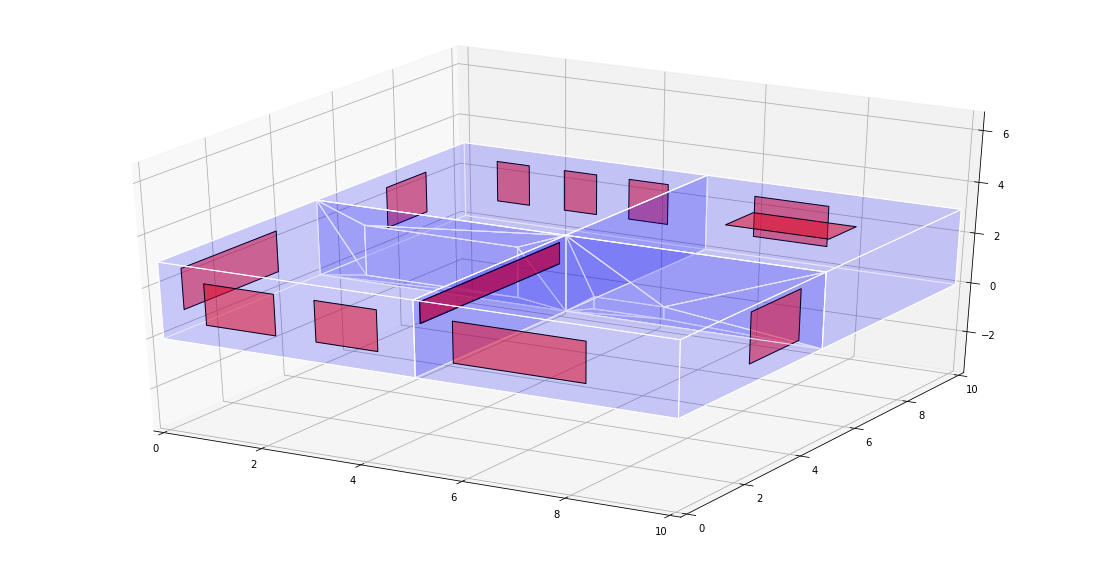

In [2]:
# Visualise the whole model!
fig = plt.figure(figsize=(15, 7.5))
ax = Axes3D(fig)
xs, ys, zs = list(zip(*np.array([item for sublist in list(zip(*[i.coords for i in idf.idfobjects["BUILDINGSURFACE:DETAILED"]])) for item in sublist])))
ax.set_xlim([min(xs), max(xs)])
ax.set_ylim([min(ys), max(ys)])
ax.set_zlim([min(zs), max(zs)])
[ax.add_collection3d(Poly3DCollection([j], facecolor=(0, 0, 1, 0.1), edgecolor="w", zorder=0)) for j in [i.coords for i in idf.idfobjects["BUILDINGSURFACE:DETAILED"]]]
[ax.add_collection3d(Poly3DCollection([j], facecolor=(1, 0, 0, 0.5), edgecolor="k", linewidth=1, zorder=-1)) for j in [i.coords for i in idf.idfobjects["FENESTRATIONSURFACE:DETAILED"]]]

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

axisEqual3D(ax)

In [3]:
# Get the unit vector between two 3D points
def unit_vector(start, end):
    dist_between = np.array(end) - np.array(start)
    return dist_between / np.sqrt(np.sum(dist_between * dist_between))

# Translate 3D coordinates with respect to the new 2D orthogonal vectors and origin point
def translated_point(e1, e2, origin, point):
    x = (point[0] - origin[0]) * e1[0] + (point[1] - origin[1]) * e1[1] + (point[2] - origin[2]) * e1[2]
    y = (point[0] - origin[0]) * e2[0] + (point[1] - origin[1]) * e2[1] + (point[2] - origin[2]) * e2[2]
    return x, y

# Untranslate translated point
def untranslated_point(e1, e2, origin, point):
    x = origin[0] + e1[0] * point[0] + e2[0] * point[1]
    y = origin[1] + e1[1] * point[0] + e2[1] * point[1]
    z = origin[2] + e1[2] * point[0] + e2[2] * point[1]
    return x, y, z

# list all building surfaces
surfaces = idf.idfobjects["BUILDINGSURFACE:DETAILED"]

# Generate list of children associated with each parent
children_vertices = []
for surface in surfaces:
    sub_child = []
    for child in idf.idfobjects["FENESTRATIONSURFACE:DETAILED"]:
        if str(child.Name.split("_")[0]) == surface.Name:
            sub_child.append(child.coords)
    children_vertices.append(sub_child)
    
parent_mask = [False if len(i) == 0 else True for i in children_vertices]
# Generate a list of surfaces without children


# For each parent containing children, subdivide the surface into triangulated surfacs, minus the children
parent_vertices = surfaces[9].coords

# Get the orthogonal unit vectors
e1 = unit_vector(parent_vertices[0], parent_vertices[1])
e2 = unit_vector(parent_vertices[0], parent_vertices[3])

# For the vertices in the parent surface, get the translated vertices in 2D plane
parent_vertices_translated = np.array([translated_point(e1, e2, parent_vertices[0], i) for i in parent_vertices])
child_vertices_translated = np.array([[translated_point(e1, e2, parent_vertices[0], i) for i in j] for j in children_vertices[9]])

# Create a Delaunay mesh of the surface
points = parent_vertices_translated
for i in child_vertices_translated:
    points = np.concatenate([points, i])

tri_total_simplices = Delaunay(points).simplices
#plt.triplot(points[:,0], points[:,1], tri_total_simplices, "g--")
#plt.plot(points[:,0], points[:,1], 'rx')

simplex_include_mask = []
for simplex in points[tri_total_simplices]:
    simplex_include_mask.append(np.invert(np.any([np.all(np.isin(simplex, i)) for i in child_vertices_translated])))

#plt.triplot(points[:,0], points[:,1], tri_total_simplices[simplex_include_mask], "b--")

# Recreate the below as surfaces for Radiance - with fenestration surfaces and air walls as air walls 
# sdetup a Radiance case using this output
points[tri_total_simplices[simplex_include_mask]]

array([[[5.        , 0.        ],
        [2.27822948, 0.80000001],
        [0.        , 0.        ]],

       [[5.        , 3.        ],
        [4.28439713, 0.80000001],
        [5.        , 0.        ]],

       [[0.89703381, 0.80000001],
        [0.        , 3.        ],
        [0.        , 0.        ]],

       [[2.27822948, 0.80000001],
        [0.89703381, 0.80000001],
        [0.        , 0.        ]],

       [[0.        , 3.        ],
        [2.27822948, 2.41547751],
        [5.        , 3.        ]],

       [[4.28439713, 2.41547751],
        [4.28439713, 0.80000001],
        [5.        , 3.        ]],

       [[0.89703381, 0.80000001],
        [0.89703381, 2.41547751],
        [0.        , 3.        ]],

       [[0.89703381, 2.41547751],
        [2.27822948, 2.41547751],
        [0.        , 3.        ]],

       [[2.27822948, 2.41547751],
        [3.07282376, 2.41547751],
        [5.        , 3.        ]],

       [[3.07282376, 2.41547751],
        [4.28439713, 2.4154775

In [ ]:
# Load SQL table output
import sqlite3
import pandas as pd

conn = sqlite3.connect(r"C:\Users\tgerrish\Desktop\SAMAzure\TestFiles\eplusout.sql")
c = conn.cursor()

print(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn))

pd.read_sql_query("SELECT * FROM ReportData", conn)

conn.close()

In [ ]:
"C:\EnergyPlusV8-8-0\energyplus.exe" -a -x -r -w "GBR_Cardiff_CIBSE_TRY.epw" "test_modified.idf"

# Below this = TESTING/NOTES

In [ ]:
# Load IDF into a list of lists (using basic text)

idf_filepath = "test.idf"

def isplit(iterable, splitters):
    return [list(g) for k,g in itertools.groupby(iterable,lambda x:x in splitters) if not k]

def nestrepl(lst, what, repl):
    for index, item in enumerate(lst):
        if type(item) == list:
            nestrepl(item, what, repl)
        else:
            if item == what:
                lst[index] = repl

with open(idf_filepath, "r") as f:
    content = isplit(isplit([re.sub("[ ]{2,}", "", re.sub("\r\n", "", re.sub("\t", "", x))) for x in f.readlines()], "")[0], "\n")
    content = [[x.replace('\n','') for x in l] for l in content]


* If length of sublist is 1 then only one value e.g. Timestep
* If sublist length of >1 then multiple values
* If count of sublist unique first values (if > 1) 


In [ ]:
Modify the following entries:


In [ ]:
# Remove unecessary parts
a = []
for i in content:
    if i[0] not in ["SizingPeriod:DesignDay,"]:
        a.append(i)
    else:
        pass
a

In [ ]:
[i[0] for i in content]